In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [2]:
# Import dataset
print("Loading dataset...")
df = pd.read_csv('conversion_data_train.csv')
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
# Remove age outlier
mask = (df['age'] < 100) & (df['age'] >= 17)
df = df[mask]

df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [4]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "converted"

X = df.drop(target_variable, axis = 1)
Y = df.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0    0
1    0
2    1
3    0
4    0
Name: converted, dtype: int64

X :
   country  age  new_user  source  total_pages_visited
0    China   22         1  Direct                    2
1       UK   21         1     Ads                    3
2  Germany   20         0     Seo                   14
3       US   23         1     Seo                    3
4       US   28         1  Direct                    3


In [5]:
# Automatically detect names of numeric/categorical columns
numeric_features = ['age', 'total_pages_visited', 'new_user']
categorical_features = ['country', 'source']

print(numeric_features)
print(categorical_features)

['age', 'total_pages_visited', 'new_user']
['country', 'source']


In [6]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [7]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first')

In [8]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [9]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
        country  age  new_user  source  total_pages_visited
70238        US   23         0  Direct                    5
11738        US   26         1     Ads                    4
51223   Germany   39         1     Ads                    2
251695       US   39         1     Seo                    8
30005        US   44         1     Seo                    2
...Done.
[[-0.91614386  0.0376251  -1.47777425  0.          0.          1.
   1.          0.        ]
 [-0.55333446 -0.2616379   0.67669334  0.          0.          1.
   0.          0.        ]
 [ 1.01883962 -0.86016391  0.67669334  1.          0.          0.
   0.          0.        ]
 [ 1.01883962  0.9354141   0.67669334  0.          0.          1.
   0.          1.        ]
 [ 1.62352196 -0.86016391  0.67669334  0.          0.          1.
   0.          1.        ]]

Encoding labels...
70238     0
11738     0
51223     0
251695    0
30005     0
Name: converted, dtype: int64
...Done
[0 0 

In [10]:
print("Grid search...")
classifier = LogisticRegression()
# Grid of values to be tested
params = {
    'solver': ['liblinear', 'sag', 'saga'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['elasticnet', 'l1', 'l2', None],
}

# Créez un scorer F1 personnalisé
f1_scorer = make_scorer(f1_score)

gridsearch = GridSearchCV(classifier, param_grid = params, cv = 5, scoring=f1_scorer) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best F1 score : ", gridsearch.best_score_)
# Print scores
print("accuracy on training set : ", accuracy_score(Y_train, gridsearch.best_estimator_.predict(X=X_train)))
print("accuracy on test set : ", accuracy_score(Y_test, gridsearch.best_estimator_.predict(X=X_test)))
print()

Grid search...


c:\Users\nicol\miniconda3\envs\jedha_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\nicol\miniconda3\envs\jedha_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\nicol\miniconda3\envs\jedha_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\nicol\miniconda3\envs\jedha_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\nicol\miniconda3\envs\jedha_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\nicol\miniconda3\envs\jedha_env

...Done.
Best hyperparameters :  {'C': 0.01, 'penalty': None, 'solver': 'sag'}
Best F1 score :  0.7633427067631884
accuracy on training set :  0.9862427633948573
accuracy on test set :  0.986190174994729



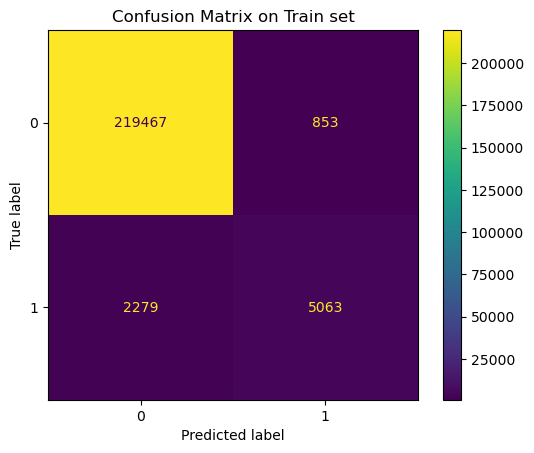

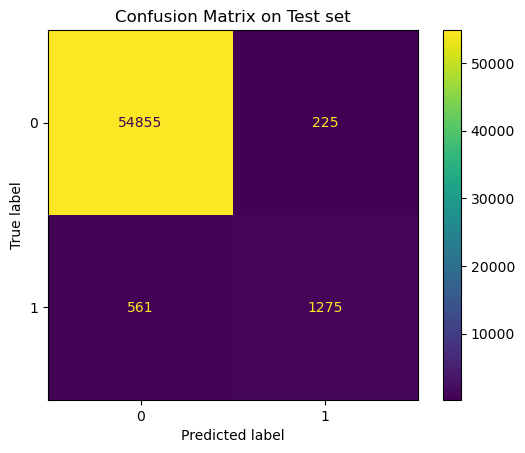

In [11]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch.best_estimator_, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch.best_estimator_, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()